In [2]:
import pandas as pd
import string
import re
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [4]:
STOPWORDS = set(stopwords.words('english'))

In [6]:
def clean(data):
    from nltk.stem.snowball import SnowballStemmer
    
    stemmer = SnowballStemmer("english")
    data=data.lower()
    data = re.sub('\[.*?\]','',data)
    data = re.sub("\\W", " ", data)
    data = re.sub('https?://\S+|www\.\S+', '', data)
    data = re.sub('<.*?>+', '', data)
    data = re.sub('[%s]' % re.escape(string.punctuation), '', data)
    data = re.sub('\n', '', data)
    data = re.sub('\w*\d\w*', '', data)
    data = ' '.join(stemmer.stem(word) for word in data.split() if word not in STOPWORDS)
    return data

In [8]:
politifact = pd.read_json(r'./data/politifact.json')
snopes = pd.read_json(r'./data/snopes.json')
poli_cols = politifact.columns.to_list()
snopes_col = snopes.columns.to_list()

In [10]:
# Merge two tables and drop the nulls

temp = poli_cols+snopes_col
temp_set = set(temp)
data_cols = ['claim','doc','topic','label']
df = pd.concat([politifact[data_cols],snopes[data_cols]], ignore_index=True)
df = df.sample(frac=1, ignore_index=True)
df =df.dropna(subset=['doc','claim','label'])

In [12]:
df['new_topic']=[' '.join(y) for y in (x for x in df['topic'])]

In [14]:
df['body'] = df['new_topic']+' '+df['claim']+df['doc']

In [15]:
%%timeit

df['body'] = df['body'].apply(clean)

3min 21s ± 30 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
df['label'] = df['label'].apply(lambda x: x.lower())

true_labels = ['correct attribution','mostly true','mostly-true', 'true',]
false_labels = ['false','mostly false','pants-fire',]

temp=[]
for index in range(len(df)):
    if df['label'][index] in true_labels:
        temp.append(0)
    elif df['label'][index] in false_labels:
        temp.append(1)
    else:
        temp.append(2)
        
df['new_label']=temp

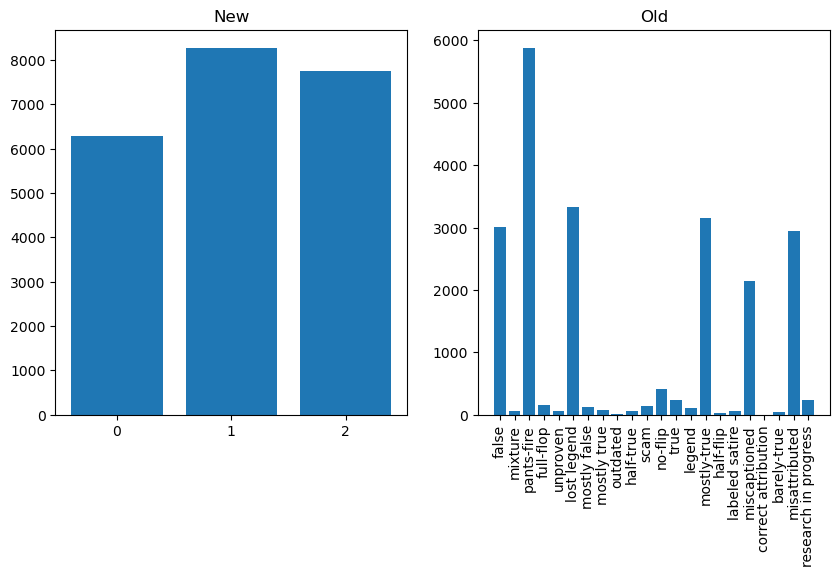

In [17]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))

ld = df.groupby(by='label').size()
new_ld = df.groupby(by='new_label').size()



ax2.bar(list(set(df['label'].tolist())), ld)
ax2.set_title('Old')


ax1.bar(['0','1','2'], new_ld)
ax1.set_title('New')


plt.xticks(rotation='vertical')
plt.show()

In [18]:
# splitting train and test data
x=df['body']

x_train, x_test, y_train, y_test = train_test_split(df['body'],df['new_label'],test_size = 0.20)#, random_state = 42)

In [19]:
# vectorizing the body column using tfidf method
tfidf_vectorizer = TfidfVectorizer()
final_x_train = tfidf_vectorizer.fit_transform(x_train)
final_x_test = tfidf_vectorizer.transform(x_test)

In [20]:
# training logestic Regression model
logestic_r = LogisticRegression()
logestic_r.fit(final_x_train,y_train)

/home/ubuntu/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [21]:
# predicting values for test data
lr_pred = logestic_r.predict(final_x_test)

In [22]:
# Build the support vector machine model

svm = SVC(kernel='linear')
svm.fit(final_x_train,y_train)
svm_pred = svm.predict(final_x_test)

In [23]:
# Ensemble model

ensemble = VotingClassifier(estimators=[('lr', logestic_r), ('svm', svm)], voting='hard')
ensemble.fit(final_x_train,y_train)
ensemble_pred = ensemble.predict(final_x_test)

/home/ubuntu/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_pred))
print("Logistic Regression Precision:", precision_score(y_test, lr_pred, average='macro'))
print("Logistic Regression Recall:", recall_score(y_test, lr_pred, average='macro'))
print("Logistic Regression F1 Score:", f1_score(y_test, lr_pred, average='macro'))
print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
print("SVM Precision:", precision_score(y_test, svm_pred, average='macro'))
print("SVM Recall:", recall_score(y_test, svm_pred, average='macro'))
print("SVM F1 Score:", f1_score(y_test, svm_pred, average='macro'))
print("Ensemble Accuracy:", accuracy_score(y_test, ensemble_pred))
print("Ensemble Precision:", precision_score(y_test, ensemble_pred, average='macro'))
print("Ensemble Recall:", recall_score(y_test, ensemble_pred, average='macro'))
print("Ensemble F1 Score:", f1_score(y_test, ensemble_pred, average='macro'))

Logistic Regression Accuracy: 0.6378923766816144
Logistic Regression Precision: 0.6343206304483804
Logistic Regression Recall: 0.6314478798750954
Logistic Regression F1 Score: 0.6325488391856244
SVM Accuracy: 0.6473094170403587
SVM Precision: 0.6472385986388073
SVM Recall: 0.6425186163159036
SVM F1 Score: 0.6440153770443511
Ensemble Accuracy: 0.6428251121076233
Ensemble Precision: 0.6384530474496444
Ensemble Recall: 0.6398167081401248
Ensemble F1 Score: 0.6389272536519006
